In [64]:
import pandas as pd
import numpy as np
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
import matplotlib.pyplot as plt 
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline 
from math import sqrt
from sklearn.metrics import mean_squared_error

In [65]:
sales = pd.read_csv('/Users/user/hts-forecast/volume/data/raw/sales_train_evaluation.csv')
cal = pd.read_csv('/Users/user/hts-forecast/volume/data/raw/calendar.csv')

### Individual functions required for this project:

In [66]:
#take the dataframe and only present the relevant category
def filter_aggregate_sales(frame, column_to_filter, column_value_to_filter, column_to_aggregate):
    frame = frame[frame[column_to_filter] == column_value_to_filter]
    frame = frame.groupby(column_to_aggregate).sum()
    return frame

In [67]:
#sum items for each day 
def total_sales(frame, column_to_sum):
    salesframe = pd.DataFrame()
    salesframe[column_to_sum] = frame.sum()
    salesframe = salesframe.reset_index()
    salesframe = salesframe.rename(columns={'index':'d'})
    return salesframe

In [68]:
#merge sales with calendar 
def merge_pd(frame1, frame2, merge_index):
    mergedframe = pd.merge(frame1, frame2, on = merge_index, how = 'inner')
    mergedframe.date = pd.to_datetime(mergedframe.date)
    return mergedframe

In [69]:
#Encode column values to binary 
def events_encode(frame, column_to_encode):
    encodedframe = frame.copy()
    encodedframe[column_to_encode] = frame[column_to_encode].fillna(0)
    for i in range(len(frame)):
        if type(frame[column_to_encode][i])==str:
            encodedframe[column_to_encode][i] = 1
    return encodedframe    

In [70]:
#Add week of year(WOY) feature 
def week_of_year(frame):
    woyframe = pd.DataFrame()
    woyframe['week_of_year'] = np.arange(len(frame))
    woyframe.week_of_year= frame.date.dt.isocalendar().week
    featureframe = frame.copy()
    featureframe['week_of_year'] = woyframe
    return featureframe

In [71]:
#ETSmodel prediction feature
def ETS_predict(frame, column_to_predict, days_to_predict):
    modelETS = ETSModel(frame.set_index('date')[column_to_predict].iloc[:-days_to_predict]/100, error="add", trend="add", seasonal="add",
                damped_trend=False, seasonal_periods=7)
    fit = modelETS.fit()
    prediction = fit.predict(start= frame.date.min(), end= frame.date.max())
    frame = frame.assign(ETS=prediction.values*100).set_index('date')
    return frame

In [72]:
#Create training/test dataset
def train_test_set(frame, target_feature, start_date, end_date):
    splittedframe = frame[start_date:end_date]
    input_train = splittedframe.drop(target_feature, axis='columns')
    target_train = splittedframe[target_feature]
    return input_train, target_train 

In [73]:
#Model and predict data using Random Forest 
def forest(X_train, y_train, X_test):
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_test)
    return y_predicted 

### Functions that use the individual functions as building blocks: 

In [74]:
#Function to combine filter_aggregate and total_sales to form day vs sales dataframe
def sort_sales(frame, column_to_filter, column_value_to_filter, column_to_aggregate):
    
    salesframe = filter_aggregate_sales(frame=frame, column_to_filter=column_to_filter,
                           column_value_to_filter=column_value_to_filter, 
                           column_to_aggregate=column_to_aggregate)
    
    salesframe = total_sales(frame=salesframe, column_to_sum=column_value_to_filter)
    
    return salesframe

In [75]:
#Function to merge sales and cal AND then create the necessary features (prior to model building)
def feature_eng(frame1, frame2, merge_index, column_to_encode):

    featureframe = merge_pd(frame1=frame1, frame2=frame2, merge_index=merge_index)
    
    featureframe = events_encode(frame=featureframe, column_to_encode=column_to_encode)
    
    featureframe = week_of_year(frame=featureframe)
    
    featureframe = featureframe.drop(['wm_yr_wk', 'weekday', 'year', 'd', 'event_name_1', 'event_name_2', 
                                          'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI'], axis='columns')
    
    return featureframe

In [76]:
#Function to create train/test split and do model and prediction
def split_n_model(frame, target_feature, train_start_date, train_end_date,
                 test_start_date, test_end_date):
    
    X_train, y_train = train_test_set(frame=frame, target_feature = target_feature,
                                      start_date=train_start_date, end_date=train_end_date)
    
    X_test, y_test   = train_test_set(frame=frame, target_feature = target_feature,
                                      start_date=test_start_date, end_date=test_end_date)
    
    y_predicted      = forest(X_train, y_train, X_test)
    
    return y_test, y_predicted

## Block function: 

In [ ]:
def run(column_value_to_filter):
    salesframe = sort_sales(frame = sales, 
                            column_to_filter = 'dept_id', 
                            column_value_to_filter=column_value_to_filter,
                            column_to_aggregate='item_id')
    
    mergedframe = feature_eng(frame1=salesframe, frame2=cal, merge_index='d',
                                column_to_encode='event_type_1')
    
    clean_mergedframe = ETS_predict(frame=mergedframe, 
                                    column_to_predict=column_value_to_filter, 
                                    days_to_predict=120)
    
    y_test, y_predicted =split_n_model(frame=clean_mergedframe, target_feature=column_value_to_filter, 
                                   train_start_date='2011-01-29', train_end_date='2016-01-22', 
                                   test_start_date='2016-01-24', test_end_date='2016-05-22')
    
    
    plt.figure(figsize=(15,6))
    plt.plot(y_test.index, y_predicted, label='Random Forest prediction')
    plt.plot(y_test, label='actual')
    plt.xlim('2016-01-24', '2016-05-22')
    plt.legend()
    plt.show()
    
    
    return

# Calculate error for each category 

categories = sales.dept_id.unique()

for cat in categories:
    print(cat)
    run(column_value_to_filter=cat)

## Do it with the 3 key functions: 

In [77]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


##### Filter, aggregate, and sum for required item, creating a "day vs sales" dataframe:

In [78]:
salesframe = sort_sales(frame = sales, column_to_filter = 'dept_id', column_value_to_filter= 'FOODS_3',
                        column_to_aggregate='item_id')
salesframe.head()





,d,FOODS_3
0,d_1,16741
1,d_2,16333
2,d_3,12343
3,d_4,13764
4,d_5,10525


HOBBIES_1


<ipython-input-69-57afc4c3509c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  encodedframe[column_to_encode][i] = 1
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


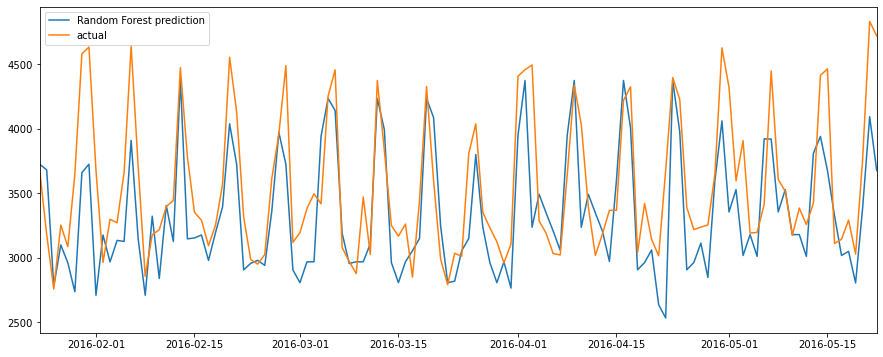

HOBBIES_2


<ipython-input-69-57afc4c3509c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  encodedframe[column_to_encode][i] = 1
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


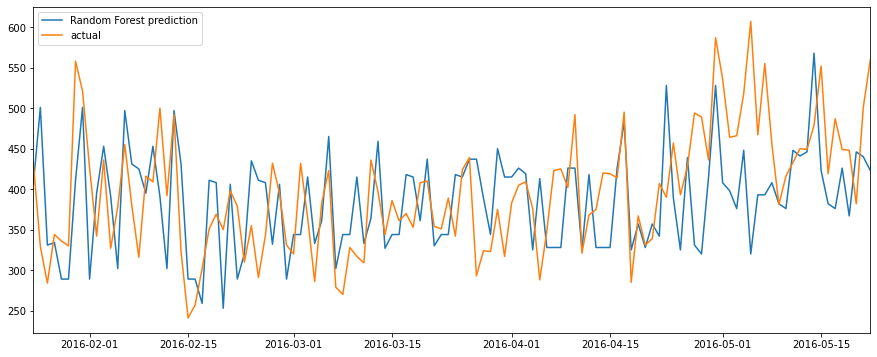

HOUSEHOLD_1


<ipython-input-69-57afc4c3509c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  encodedframe[column_to_encode][i] = 1
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


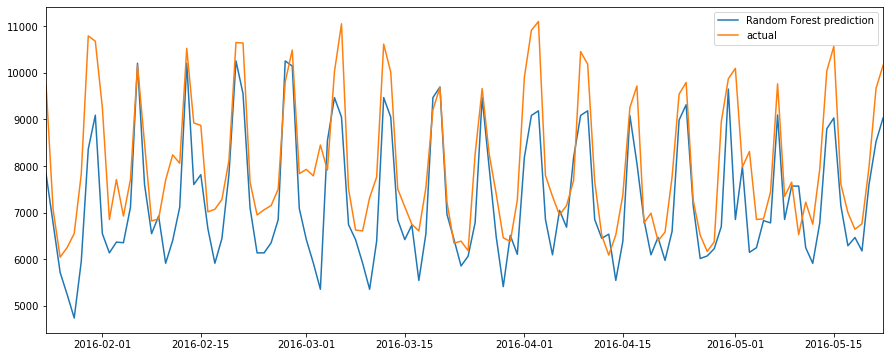

HOUSEHOLD_2


<ipython-input-69-57afc4c3509c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  encodedframe[column_to_encode][i] = 1
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


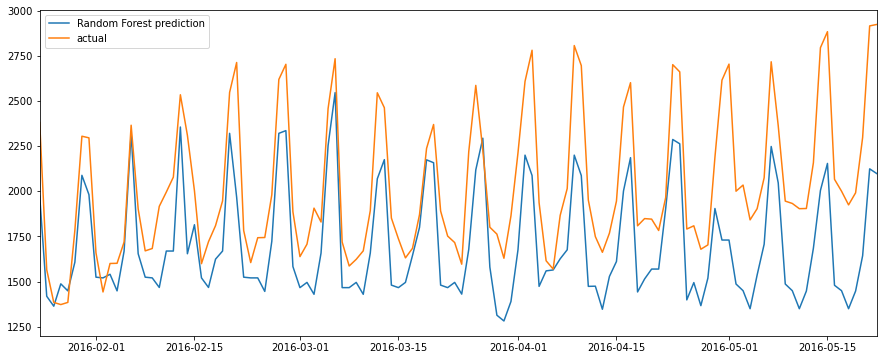

FOODS_1


<ipython-input-69-57afc4c3509c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  encodedframe[column_to_encode][i] = 1
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


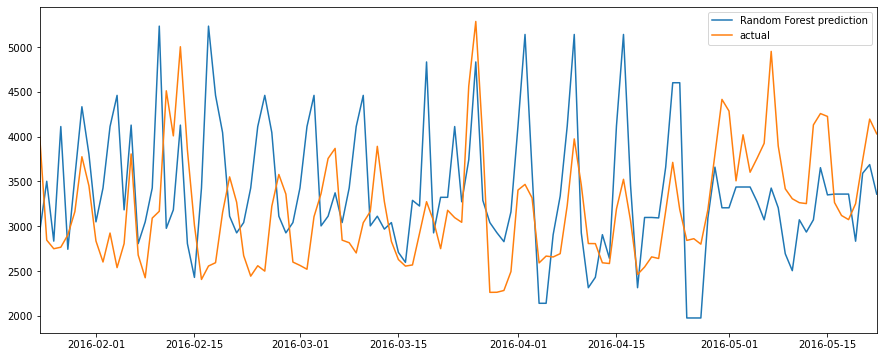

FOODS_2


<ipython-input-69-57afc4c3509c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  encodedframe[column_to_encode][i] = 1
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


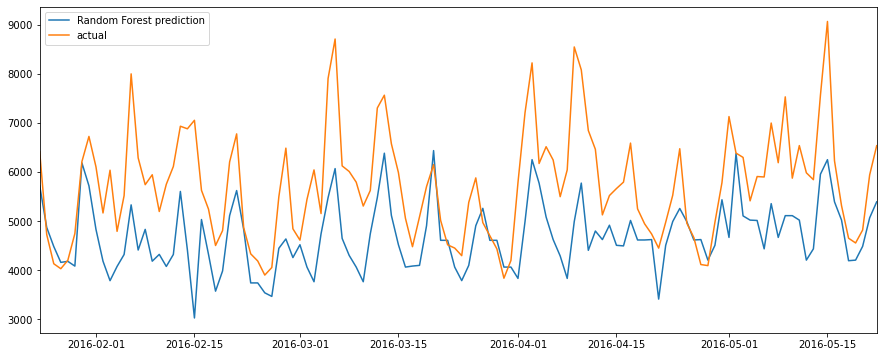

FOODS_3


<ipython-input-69-57afc4c3509c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  encodedframe[column_to_encode][i] = 1
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


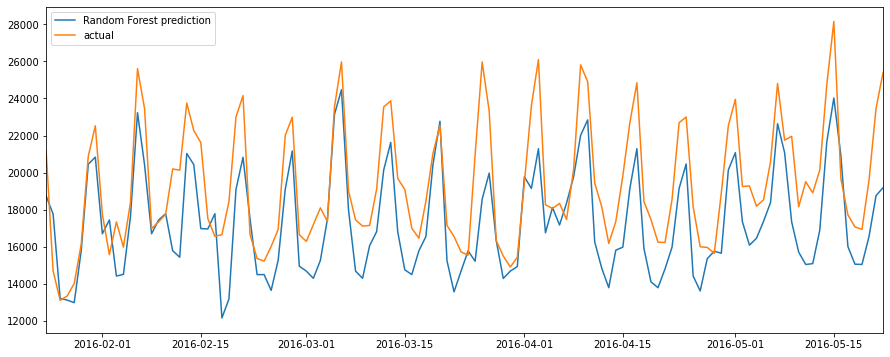

In [79]:
salesframe.shape

(1941, 2)

##### Merge with calendar, do feature engineering and create "features" dataframe:

In [80]:
mergedframe = feature_eng(frame1=salesframe, frame2=cal, merge_index='d',
                                column_to_encode='event_type_1')
mergedframe.head()

<ipython-input-69-57afc4c3509c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  encodedframe[column_to_encode][i] = 1


,FOODS_3,date,wday,month,event_type_1,week_of_year
0,16741,2011-01-29,1,1,0,4
1,16333,2011-01-30,2,1,0,4
2,12343,2011-01-31,3,1,0,5
3,13764,2011-02-01,4,2,0,5
4,10525,2011-02-02,5,2,0,5


##### Add ETS prediction as a feature:

In [81]:
clean_mergedframe = ETS_predict(frame=mergedframe, column_to_predict='FOODS_3', days_to_predict=120)
clean_mergedframe.head()

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


,FOODS_3,wday,month,event_type_1,week_of_year,ETS
date,,,,,,
2011-01-29,16741,1,1,0,4,14360.207831
2011-01-30,16333,2,1,0,4,15197.741548
2011-01-31,12343,3,1,0,5,12000.992396
2011-02-01,13764,4,2,0,5,11521.478058
2011-02-02,10525,5,2,0,5,11963.640047


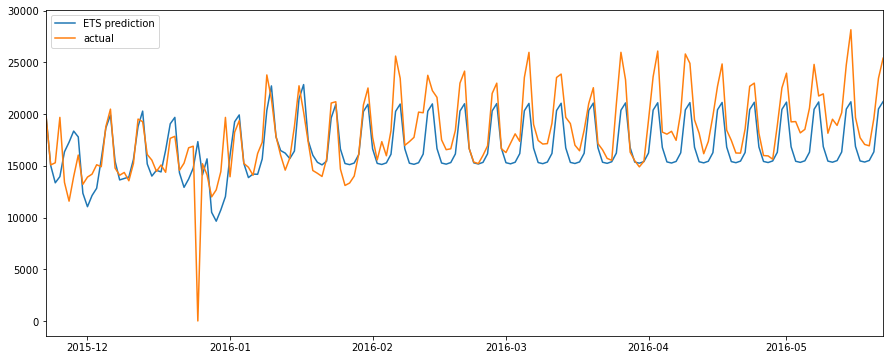

In [82]:
plt.figure(figsize=(15,6))
plt.plot(clean_mergedframe.ETS, label='ETS prediction')
plt.plot(clean_mergedframe.FOODS_3, label='actual')
plt.xlim('2015-11-22', '2016-05-22')
plt.legend()

##### Do the train/test split, modelling and prediction for required dates:

In [83]:
y_test, y_predicted =split_n_model(frame=clean_mergedframe, target_feature='FOODS_3', 
                                   train_start_date='2011-01-29', train_end_date='2016-01-22', 
                                   test_start_date='2016-01-24', test_end_date='2016-05-22')


In [84]:
print(y_test.shape, y_predicted.shape)

(120,) (120,)


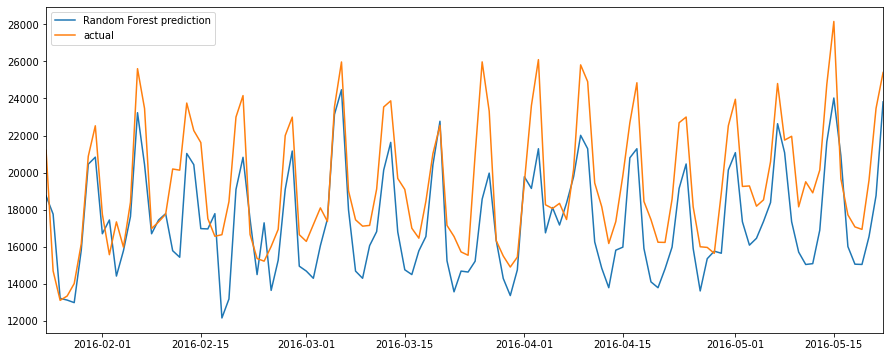

In [85]:
plt.figure(figsize=(15,6))
plt.plot(y_test.index, y_predicted, label='Random Forest prediction')
plt.plot(y_test, label='actual')
plt.xlim('2016-01-24', '2016-05-22')
plt.legend()

In [86]:
#Compare FOODS_3 average sales with RMSE 
print("Average sales for foods(3) items is: ", y_test.mean())
rmse = sqrt(mean_squared_error(y_test, y_predicted))
print("Root mean squared error is: ", rmse)

Average sales for foods(3) items is:  19364.208333333332
Root mean squared error is:  2638.926083656001


### Do it with individual functions (not with 3 key functions): 

In [87]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [88]:
df1 = filter_aggregate_sales(frame=sales, column_to_filter='dept_id', column_value_to_filter='FOODS_3',column_to_aggregate='item_id')
df1.head()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
item_id,,,,,,,,,,,,,,,,,,,,,
FOODS_3_001,7,8,7,13,5,8,10,19,14,9,...,4,7,11,4,5,8,11,9,12,13
FOODS_3_002,0,0,0,0,0,0,0,0,0,0,...,33,41,42,41,35,19,23,23,35,26
FOODS_3_003,0,0,0,0,0,0,0,0,0,0,...,11,7,13,10,3,5,7,7,3,6
FOODS_3_004,0,0,0,0,0,0,0,0,0,0,...,3,7,2,1,3,5,4,6,6,2
FOODS_3_005,4,9,3,10,7,12,6,9,12,6,...,7,11,11,11,6,8,13,16,6,16


In [89]:
df1.shape

(823, 1941)

In [90]:
df3 = total_sales(frame=df1, column_to_sum='FOODS_3')
df3.head()

,d,FOODS_3
0,d_1,16741
1,d_2,16333
2,d_3,12343
3,d_4,13764
4,d_5,10525


In [91]:
df4 = merge_pd(cal, df3, 'd')
df4.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,FOODS_3
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,16741
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,16333
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,12343
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,13764
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,10525


In [92]:
df5 = df4.drop(['wm_yr_wk', 'weekday', 'year', 'd', 'event_name_1', 'event_name_2', 
            'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI'], axis='columns')
df5.head()

,date,wday,month,event_type_1,FOODS_3
0,2011-01-29,1,1,NaN,16741
1,2011-01-30,2,1,NaN,16333
2,2011-01-31,3,1,NaN,12343
3,2011-02-01,4,2,NaN,13764
4,2011-02-02,5,2,NaN,10525


In [93]:
df5.groupby('event_type_1')['event_type_1'].agg('count')

event_type_1
Cultural     37
National     51
Religious    54
Sporting     16
Name: event_type_1, dtype: int64

In [94]:
df6 = events_encode(frame=df5, column_to_encode='event_type_1')
df6.head()

<ipython-input-69-57afc4c3509c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  encodedframe[column_to_encode][i] = 1


,date,wday,month,event_type_1,FOODS_3
0,2011-01-29,1,1,0,16741
1,2011-01-30,2,1,0,16333
2,2011-01-31,3,1,0,12343
3,2011-02-01,4,2,0,13764
4,2011-02-02,5,2,0,10525


In [95]:
df6.groupby('event_type_1')['event_type_1'].agg('count')

event_type_1
0    1783
1     158
Name: event_type_1, dtype: int64

In [96]:
df7 = week_of_year(frame=df6)
df7.head()

,date,wday,month,event_type_1,FOODS_3,week_of_year
0,2011-01-29,1,1,0,16741,4
1,2011-01-30,2,1,0,16333,4
2,2011-01-31,3,1,0,12343,5
3,2011-02-01,4,2,0,13764,5
4,2011-02-02,5,2,0,10525,5


In [97]:
df8 = ETS_predict(frame=df7, column_to_predict='FOODS_3', days_to_predict=120)
df8

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


,wday,month,event_type_1,FOODS_3,week_of_year,ETS
date,,,,,,
2011-01-29,1,1,0,16741,4,14360.207831
2011-01-30,2,1,0,16333,4,15197.741548
2011-01-31,3,1,0,12343,5,12000.992396
2011-02-01,4,2,0,13764,5,11521.478058
2011-02-02,5,2,0,10525,5,11963.640047
...,...,...,...,...,...,...
2016-05-18,5,5,0,17069,20,15367.524582
2016-05-19,6,5,0,16935,20,15521.681264
2016-05-20,7,5,0,19586,20,16354.892664


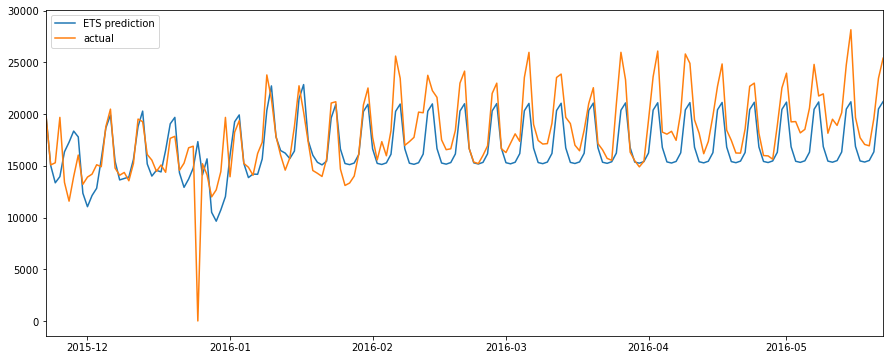

In [98]:
plt.figure(figsize=(15,6))
plt.plot(df8.ETS, label='ETS prediction')
plt.plot(df6.date, df6.FOODS_3, label='actual')
plt.xlim('2015-11-22', '2016-05-22')
plt.legend()

In [99]:
X_train,y_train = train_test_set(frame=df8, target_feature='FOODS_3', start_date='2011-01-29', end_date='2016-01-22')

In [100]:
print(X_train.shape, y_train.shape)

(1820, 5) (1820,)


In [101]:
X_test,y_test = train_test_set(frame=df8, target_feature='FOODS_3', start_date='2016-01-24', end_date='2016-05-22')

In [102]:
print(X_test.shape, y_test.shape)

(120, 5) (120,)


In [103]:
y_predicted = forest(X_train=X_train, y_train=y_train, X_test=X_test)
y_predicted

array([18746, 12368, 13216, 13120, 12983, 15807, 20452, 20832, 16699,
       17443, 14416, 14509, 17630, 23231, 20427, 16699, 17443, 13070,
       15784, 15432, 21030, 20427, 16976, 16960, 13070, 12155, 13180,
       21364, 20824, 17484, 14496, 14496, 13644, 15271, 19091, 20824,
       14949, 14684, 14296, 16058, 17492, 23136, 24470, 17986, 14684,
       14296, 16058, 16815, 20134, 21629, 16797, 14755, 14497, 15778,
       16548, 20421, 22768, 15240, 13566, 14684, 15778, 15216, 18567,
       19970, 16337, 14287, 13363, 14748, 19775, 19144, 21595, 16749,
       18114, 17171, 18357, 19775, 22010, 21287, 16261, 14842, 15234,
       15813, 15976, 19144, 21287, 15905, 14103, 13788, 14806, 15979,
       19144, 20464, 14418, 14103, 15354, 15758, 15648, 20141, 21075,
       17347, 16084, 16454, 10485, 18384, 22637, 21075, 17347, 15709,
       15041, 15086, 16893, 21658, 24023, 20912, 16007, 15057, 15043,
       16545, 18756, 23815])

In [104]:
print(len(y_test), len(y_predicted))

120 120


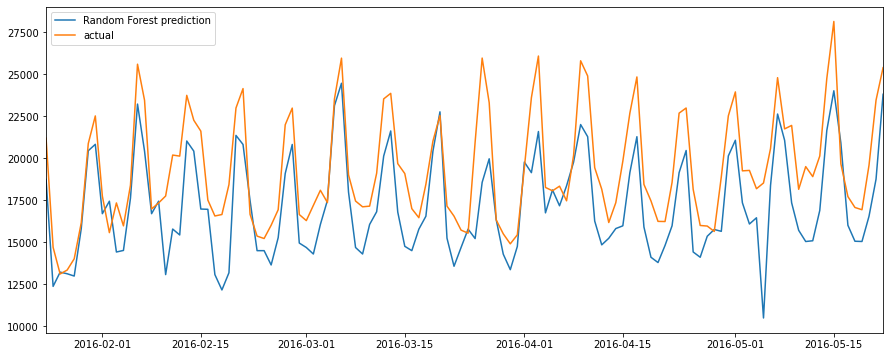

In [105]:
plt.figure(figsize=(15,6))
plt.plot(X_test.index, y_predicted, label='Random Forest prediction')
plt.plot(y_test, label='actual')
plt.xlim('2016-01-24', '2016-05-22')
plt.legend()

In [106]:
len(df8['2016-01-24':'2016-05-22'])

120

In [107]:
#Compare FOODS_3 average sales with RMSE 
print("Average sales for foods(3) items is: ", y_test.mean())
rmse = sqrt(mean_squared_error(y_test, y_predicted))
print("Root mean squared error is: ", rmse)

Average sales for foods(3) items is:  19364.208333333332
Root mean squared error is:  2772.109159406726
